https://huggingface.co/blog/deep-rl-pg

https://colab.research.google.com/github/huggingface/deep-rl-class/blob/main/unit5/unit5.ipynb#scrollTo=NCNvyElRStWG

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import gym

!pip install JSAnimation
!pip install pygame

from JSAnimation.IPython_display import display_animation
from matplotlib import animation
from IPython.display import display

%matplotlib inline

def display_frames_as_gif(frames):
  plt.figure(figsize=(frames[0].shape[1] / 72.0, frames[0].shape[0] / 72.0), dpi=72)
  patch = plt.imshow(frames[0])
  plt.axis('off')
  def animate(i):
    patch.set_data(frames[i])
  anim = animation.FuncAnimation(plt.gcf(), animate, frames=len(frames), interval=50)
  anim.save('move_cartpole_DQN.mp4')
  #display(display_animation(anim, default_mode='loop'))


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for JSAnimation: filename=JSAnimation-0.1-py3-none-any.whl size=11423 sha256=083b06a5dfe9d5fe6944138266bbc8cdba6ef849e2e1f2d4ca00d2eb6ae10b89
  Stored in directory: /root/.cache/pip/wheels/b1/78/80/8fa3ee5db5b384c086dcc7e6c4e4e22caae0687a4f71ba08f8
Successfully built JSAnimation
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.8/21.8 MB 70.4 MB/s eta 0:00:00


In [3]:

ENV = 'CartPole-v0'
GAMMA = 0.99
MAX_STEPS = 200
NUM_EPISODES = 1000

In [4]:
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torch.distributions import Categorical

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class BrainREINFORCE(nn.Module):
  def __init__(self, num_states, num_actions):
    super(BrainREINFORCE, self).__init__()
    self.fc1 = nn.Linear(num_states, 32)
    self.fc2 = nn.Linear(32, num_actions)
  
  def forward(self, state):
    x = F.relu(self.fc1(state))
    y = self.fc2(x)
    return F.softmax(y, dim=1)

  def act(self, state):
    probs = self.forward(state.to(device)).cpu()
    model = Categorical(probs)
    action = model.sample()
    return action, model.log_prob(action)

In [5]:
class Environment:

    def __init__(self):
        self.env = gym.make(ENV)  # 実行する課題を設定
        self.num_states = self.env.observation_space.shape[0]  # 課題の状態数4を取得
        self.num_actions = self.env.action_space.n  # CartPoleの行動（右に左に押す）の2を取得
        #self.device = torch.device("cpu")
        self.brain = BrainREINFORCE(self.num_states, self.num_actions).to(device)
        self.optimizer = optim.Adam(self.brain.parameters(), lr=1e-2)
        for param in self.brain.parameters():
          print(param)

        
    def run(self):
        '''実行'''
        episode_10_list = np.zeros(10)  # 10試行分の立ち続けたstep数を格納し、平均ステップ数を出力に利用
        complete_episodes = 0  # 195step以上連続で立ち続けた試行数
        episode_final = False  # 最後の試行フラグ
        frames = []  # 最後の試行を動画にするために画像を格納する変数

        for episode in range(NUM_EPISODES):  # 最大試行数分繰り返す
            if episode + 1 == NUM_EPISODES:
              episode_final = True
            observation = self.env.reset()  # 環境の初期化

            state = observation  # 観測をそのまま状態sとして使用
            state = torch.from_numpy(state).type(
                torch.FloatTensor)  # NumPy変数をPyTorchのテンソルに変換
            state = torch.unsqueeze(state, 0)  # size 4をsize 1x4に変換

            saved_log_probs = []
            rewards = [] 
            policy_loss = [] 

            for step in range(MAX_STEPS):  # 1エピソードのループ

                if episode_final is True:  # 最終試行ではframesに各時刻の画像を追加していく
                    frames.append(self.env.render(mode='rgb_array'))

                action, log_prob = self.brain.act(state)

                # 行動a_tの実行により、s_{t+1}とdoneフラグを求める
                # actionから.item()を指定して、中身を取り出す
                observation_next, _, done, _ = self.env.step(
                    action.item())  # rewardとinfoは使わないので_にする

                # 報酬を与える。さらにepisodeの終了評価と、state_nextを設定する
                if done:  # ステップ数が200経過するか、一定角度以上傾くとdoneはtrueになる
                    state_next = None  # 次の状態はないので、Noneを格納

                    # 直近10episodeの立てたstep数リストに追加
                    episode_10_list = np.hstack(
                        (episode_10_list[1:], step + 1))

                    if step < 195:
                        reward = torch.FloatTensor(
                            [-1.0])  # 途中でこけたら罰則として報酬-1を与える
                        complete_episodes = 0  # 連続成功記録をリセット
                    else:
                        reward = torch.FloatTensor([1.0])  # 立ったまま終了時は報酬1を与える
                        complete_episodes = complete_episodes + 1  # 連続記録を更新
                else:
                    reward = torch.FloatTensor([0.0])  # 普段は報酬0
                    state_next = observation_next  # 観測をそのまま状態とする
                    state_next = torch.from_numpy(state_next).type(
                        torch.FloatTensor)  # numpy変数をPyTorchのテンソルに変換
                    state_next = torch.unsqueeze(state_next, 0)  # size 4をsize 1x4に変換

                saved_log_probs.append(log_prob)
                rewards.append(reward)

                # 観測の更新
                state = state_next

                # 終了時の処理
                if done:
                    print('%d Episode: Finished after %d steps：10試行の平均step数 = %.1lf' % (
                        episode, step + 1, episode_10_list.mean()))
                    break

            Gs = []
            G = 0
            for t in range(len(rewards))[::-1]:
              G = G * GAMMA + rewards[t]
              Gs.append(G)
            Gs.reverse()
            eps = np.finfo(np.float32).eps.item()
            ## eps is the smallest representable float, which is 
            # added to the standard deviation of the returns to avoid numerical instabilities        
            Gs = torch.tensor(Gs)
            Gs = (Gs - Gs.mean()) / (Gs.std() + eps)
            for t in range(len(rewards)):
              policy_loss.append(-saved_log_probs[t].cpu() * Gs[t].cpu())
            
            posum = torch.cat(policy_loss).sum()
            self.optimizer.zero_grad()
            posum.backward()
            self.optimizer.step()
            policy_loss = []

            if episode_final is True:
                # 動画を保存と描画
                display_frames_as_gif(frames)
                break

            # 10連続で200step経ち続けたら成功
            if complete_episodes >= 10:
                print('10回連続成功')
                episode_final = True  # 次の試行を描画を行う最終試行とする

/usr/local/lib/python3.8/dist-packages/gym/envs/registration.py:593: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.warn(
/usr/local/lib/python3.8/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.8/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


Parameter containing:
tensor([[-0.1502, -0.2832, -0.0740, -0.2210],
        [ 0.1231,  0.3009, -0.1906, -0.4975],
        [-0.0703,  0.4950, -0.3710, -0.0197],
        [-0.1337,  0.4933,  0.4469, -0.0445],
        [ 0.2968,  0.2675,  0.3761,  0.1883],
        [ 0.4301, -0.0639, -0.3559,  0.1947],
        [-0.1960, -0.2591, -0.4299, -0.1507],
        [ 0.1251, -0.3906,  0.1136, -0.0019],
        [ 0.2218,  0.4534, -0.3026, -0.3741],
        [ 0.4787, -0.4122,  0.4196, -0.2891],
        [-0.2920, -0.1488, -0.2250,  0.1212],
        [-0.0485,  0.1282, -0.4965, -0.4490],
        [-0.2780,  0.4233,  0.4461, -0.0496],
        [-0.3438,  0.4629, -0.1467, -0.0699],
        [ 0.1779,  0.1403,  0.2182, -0.4479],
        [ 0.2357,  0.2482, -0.2722,  0.4199],
        [ 0.4583,  0.2492, -0.2198, -0.1688],
        [-0.0988,  0.2104,  0.3038, -0.3742],
        [ 0.0153,  0.4515,  0.2011, -0.0533],
        [-0.4693, -0.4220, -0.4533, -0.3501],
        [ 0.2895, -0.1092,  0.2817, -0.2072],
        [-0.

/usr/local/lib/python3.8/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(


155 Episode: Finished after 200 steps：10試行の平均step数 = 200.0


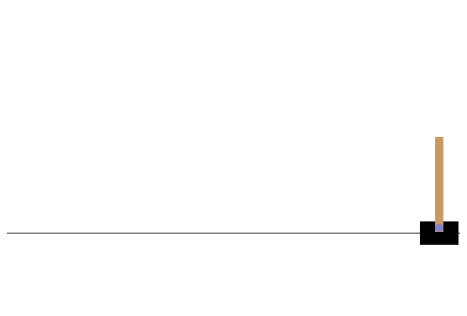

In [6]:
cartpole_env = Environment()
cartpole_env.run()